<a href="https://colab.research.google.com/github/IEncryptSaad/DASHCAM-ANOMALY-CLASSIFIER/blob/main/Dashcam_Anomaly_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DASHCAM ANOMALY CLASSIFIER**

*(Classify unsafe driving events using image classification and CNNs)*

In [9]:
## STEP NO. 1: Setup & Imports

In [10]:
# Install packages
!pip install -q tensorflow opencv-python-headless

# 📚 Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


In [11]:
# STEP 1: Install Kaggle CLI (only once)
!pip install -q kaggle

# STEP 2: Upload your kaggle.json file
from google.colab import files
uploaded = files.upload()  # ← Upload your file here, e.g., "kaggle (1).json"

# STEP 3: Rename the file to avoid issues with spaces and parentheses
import os
for fname in uploaded.keys():
    os.rename(fname, "kaggle.json")

# STEP 4: Move kaggle.json to the proper directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 5: Test Kaggle access by listing datasets (optional)
!kaggle datasets list -s dashcam


Saving kaggle.json to kaggle (1).json
ref                                                            title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
mdfahimbinamin/car-crash-or-collision-prediction-dataset       Car Crash or Collision Prediction Dataset          1136372754  2024-08-28 18:13:08.690000           1370         27  1.0              
asefjamilajwad/car-crash-dataset-ccd                           Car Crash Dataset (CCD)                            8172819791  2022-07-05 18:12:45.967000           1806         26  0.9411765        
balraj98/cityscapes-pix2pix-dataset                            Cityscapes Pix2Pix Dataset                          105595335  2020-10-18 08:10:17.600000            680   

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aiyazm/accident-detection")

print("Path to dataset files:", path)

100%|██████████| 7.61G/7.61G [06:05<00:00, 22.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1


In [13]:
# Check what files/folders are inside the downloaded dataset
!ls -R /root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1


Streaming output truncated to the last 5000 lines.
12674.jpg  19848.jpg  2701.jpg	 34193.jpg  41366.jpg  4853.jpg   55712.jpg
12675.jpg  19849.jpg  27020.jpg  34194.jpg  41367.jpg  48540.jpg  55713.jpg
12676.jpg  1984.jpg   27021.jpg  34195.jpg  41368.jpg  48541.jpg  55714.jpg
12677.jpg  19850.jpg  27022.jpg  34196.jpg  41369.jpg  48542.jpg  55715.jpg
12678.jpg  19851.jpg  27023.jpg  34197.jpg  4136.jpg   48543.jpg  55716.jpg
12679.jpg  19852.jpg  27024.jpg  34198.jpg  41370.jpg  48544.jpg  55717.jpg
1267.jpg   19853.jpg  27025.jpg  34199.jpg  41371.jpg  48545.jpg  55718.jpg
12680.jpg  19854.jpg  27026.jpg  3419.jpg   41372.jpg  48546.jpg  55719.jpg
12681.jpg  19855.jpg  27027.jpg  341.jpg    41373.jpg  48547.jpg  5571.jpg
12682.jpg  19856.jpg  27028.jpg  34200.jpg  41374.jpg  48548.jpg  55720.jpg
12683.jpg  19857.jpg  27029.jpg  34201.jpg  41375.jpg  48549.jpg  55721.jpg
12684.jpg  19858.jpg  2702.jpg	 34202.jpg  41376.jpg  4854.jpg   55722.jpg
12685.jpg  19859.jpg  27030.jpg  34203.j

In [14]:
#Check If There’s a Metadata File
!find /root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1 -type f


Streaming output truncated to the last 5000 lines.
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55703.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55704.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55705.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55706.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55707.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55708.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/55709.jpg
/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder/5571.jp

In [16]:
!ls -R /content/accident_data


ls: cannot access '/content/accident_data': No such file or directory


In [17]:
import os
import shutil

# Actual nested folders (corrected paths)
accident_src = "/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/accident_folder/accident_folder"
nonacc_src = "/root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder"

# Destination folders for training
target_base = "/content/accident_data"
accident_dst = os.path.join(target_base, "accident")
nonacc_dst = os.path.join(target_base, "non_accident")

# Ensure the destination folders exist
os.makedirs(accident_dst, exist_ok=True)
os.makedirs(nonacc_dst, exist_ok=True)

# Copy function: only image files
def copy_images(src_dir, dst_dir):
    copied = 0
    for fname in os.listdir(src_dir):
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if os.path.isfile(src) and fname.lower().endswith((".jpg", ".jpeg", ".png")):
            shutil.copy2(src, dst)
            copied += 1
    print(f"Copied {copied} files from {src_dir} to {dst_dir}")

# Perform the copy
copy_images(accident_src, accident_dst)
copy_images(nonacc_src, nonacc_dst)


Copied 19216 files from /root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/accident_folder/accident_folder to /content/accident_data/accident
Copied 55784 files from /root/.cache/kagglehub/datasets/aiyazm/accident-detection/versions/1/non_accident_folder/non_accident_folder to /content/accident_data/non_accident


In [18]:
!ls /content/accident_data/accident | head
!ls /content/accident_data/non_accident | head


0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset path
data_dir = "/content/accident_data"

# Create data generators with preprocessing and augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 60001 images belonging to 2 classes.
Found 14999 images belonging to 2 classes.


In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without top layers and freeze weights
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze all pretrained layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # reduce tensor to vector
x = Dropout(0.3)(x)              # optional regularization
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # binary classification output

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model with binary crossentropy and Adam optimizer
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Model summary (optional)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save best model only
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Stop training early if no improvement
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7515 - loss: 0.5414
Epoch 1: val_accuracy improved from -inf to 0.72805, saving model to best_model.h5


1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1063s 559ms/step - accuracy: 0.7515 - loss: 0.5414 - val_accuracy: 0.7280 - val_loss: 0.6027
Epoch 2/10
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7861 - loss: 0.4765
Epoch 2: val_accuracy improved from 0.72805 to 0.73338, saving model to best_model.h5


1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1016s 542ms/step - accuracy: 0.7861 - loss: 0.4765 - val_accuracy: 0.7334 - val_loss: 0.6093
Epoch 3/10
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7934 - loss: 0.4606
Epoch 3: val_accuracy did not improve from 0.73338
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1015s 541ms/step - accuracy: 0.7934 - loss: 0.4606 - val_accuracy: 0.7206 - val_loss: 0.6207
Epoch 4/10
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7980 - loss: 0.4497
Epoch 4: val_accuracy did not improve from 0.73338
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1012s 539ms/step - accuracy: 0.7980 - loss: 0.4497 - val_accuracy: 0.7071 - val_loss: 0.6439


In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model
model = load_model("best_model.h5")

# Recompile it (required after loading)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Continue training for more epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6,  # number of additional epochs
    callbacks=[checkpoint]  # include early_stop here if you want
)


Epoch 1/6
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7943 - loss: 0.4576
Epoch 1: val_accuracy improved from 0.73338 to 0.73432, saving model to best_model.h5


1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1038s 549ms/step - accuracy: 0.7943 - loss: 0.4576 - val_accuracy: 0.7343 - val_loss: 0.6198
Epoch 2/6
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7975 - loss: 0.4498
Epoch 2: val_accuracy did not improve from 0.73432
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1008s 537ms/step - accuracy: 0.7975 - loss: 0.4498 - val_accuracy: 0.7035 - val_loss: 0.6438
Epoch 3/6
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8022 - loss: 0.4422
Epoch 3: val_accuracy did not improve from 0.73432
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1012s 539ms/step - accuracy: 0.8022 - loss: 0.4422 - val_accuracy: 0.7028 - val_loss: 0.6500
Epoch 4/6
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8018 - loss: 0.4370
Epoch 4: val_accuracy did not improve from 0.73432
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 1010s 538ms/step - accuracy: 0.8018 - loss: 0.4370 - val_accuracy: 0.6940 - val_loss: 0.6710
Epoch 5/6
1876/1876 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8087 - loss: 0.

**(Phase 5: Evaluation & Testing)**

In [25]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {test_acc:.4f}, Validation Loss: {test_loss:.4f}")


469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 423ms/step - accuracy: 0.6917 - loss: 0.6662
Validation Accuracy: 0.6882, Validation Loss: 0.6691


**(Phase 6: Finalization)**

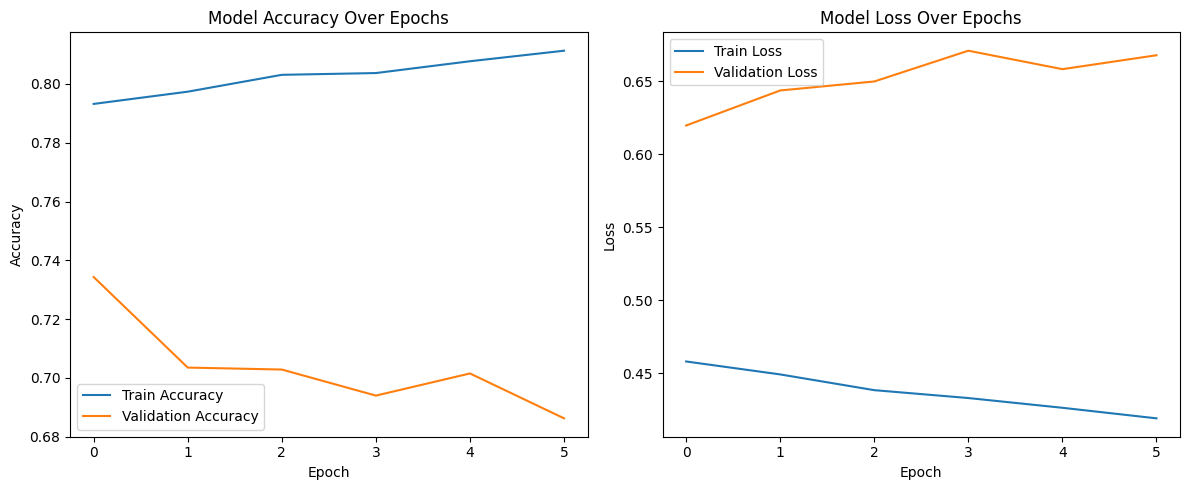

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the best saved model
model = load_model("best_model.h5")

# Re-compile the model to resume training or evaluation
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


In [38]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


352/352 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.5146 - loss: 0.8858
Test Accuracy: 0.7858, Test Loss: 0.4766


In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Get ground truth labels and predictions
Y_true = test_generator.classes
Y_pred_probs = model.predict(test_generator)
Y_pred = (Y_pred_probs > 0.5).astype(int).reshape(-1)  # Threshold for binary classification

# Step 2: Classification Report
print("Classification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=test_generator.class_indices.keys()))


352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 160ms/step
Classification Report:

              precision    recall  f1-score   support

    accident       0.78      0.20      0.32      2883
non_accident       0.78      0.98      0.87      8368

    accuracy                           0.78     11251
   macro avg       0.78      0.59      0.60     11251
weighted avg       0.78      0.78      0.73     11251



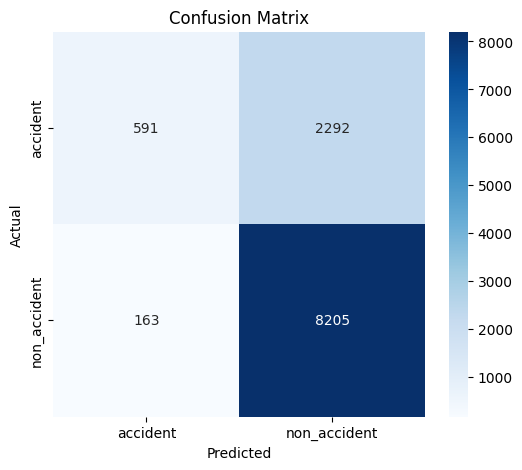

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()


In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Save metrics
acc = accuracy_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)

with open("evaluation_metrics.txt", "w") as f:
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")

print("Evaluation metrics saved to evaluation_metrics.txt")


Evaluation metrics saved to evaluation_metrics.txt


In [46]:
summary = """
📊 MODEL EVALUATION SUMMARY

✅ Overall Accuracy: 78%
- This means the model correctly classifies 78 out of every 100 frames.

📍 Class-wise Metrics:
- 'Accident':
  - Precision: 0.78 (correctly labeled accidents among all predicted accidents)
  - Recall: 0.20 (missed many true accident cases)
  - F1-score: 0.32

- 'Non-Accident':
  - Precision: 0.78
  - Recall: 0.98 (almost all non-accidents correctly identified)
  - F1-score: 0.87

🧠 Confusion Matrix Insights:
- False Negatives (missed accidents) are high — 2292 out of 2883
- True Negatives (non-accidents correctly identified): 8205

📈 Learning Curves:
- Training accuracy improved steadily.
- Validation accuracy plateaued and dipped slightly — suggests overfitting.

📦 Saved Files:
- Best model: best_model.h5
- Confusion matrix plot: confusion_matrix.png
- Classification report: evaluation_metrics.txt
"""

with open("final_report.txt", "w") as f:
    f.write(summary)

print("✅ Final report saved to final_report.txt")


✅ Final report saved to final_report.txt


In [47]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
